
[Vecino Más Cercano]
Ruta calculada: [588, 586, 607, 577, 581, 562, 571, 578, 600, 601, 611, 584, 579, 575, 589, 580, 612, 617, 621, 590, 567, 602, 630, 613, 622, 618, 632, 633, 623, 614, 591, 576, 585, 572, 558, 559, 551, 543, 539, 527, 518, 509, 513, 519, 522, 520, 515, 501, 481, 473, 483, 463, 449, 455, 460, 472, 476, 490, 500, 494, 485, 493, 508, 499, 498, 479, 470, 465, 454, 462, 480, 504, 512, 517, 526, 536, 523, 537, 535, 514, 492, 489, 488, 503, 511, 548, 564, 604, 610, 616, 624, 619, 615, 606, 599, 592, 573, 552, 541, 534, 533, 538, 530, 507, 486, 475, 458, 442, 436, 422, 416, 410, 418, 408, 435, 400, 378, 370, 369, 360, 339, 328, 329, 321, 324, 316, 298, 291, 310, 323, 334, 342, 351, 341, 355, 344, 359, 363, 373, 406, 405, 417, 430, 433, 431, 437, 457, 477, 487, 502, 505, 491, 484, 506, 521, 525, 550, 561, 587, 598, 626, 636, 635, 639, 648, 656, 670, 680, 684, 689, 673, 677, 669, 657, 660, 674, 682, 690, 699, 698, 700, 703, 707, 714, 717, 727, 732, 733, 729, 728, 730, 731, 7

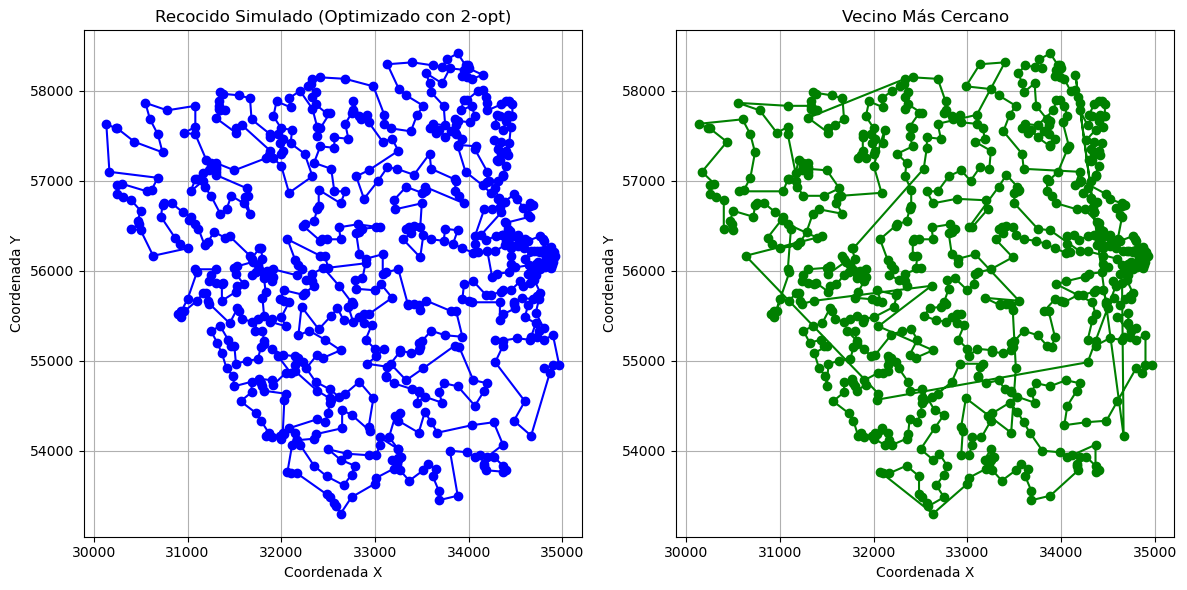

In [19]:
import math
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Función para cargar datos desde el archivo
def cargar_datos(archivo):
    datos = np.loadtxt(archivo)
    identificadores = datos[:, 0].astype(int)  # Identificadores de las ciudades
    x = datos[:, 1]  # Coordenadas x
    y = datos[:, 2]  # Coordenadas y
    return identificadores, x, y

# Función para calcular la matriz de distancias
def calcular_matriz_distancias(x, y):
    n = len(x)
    matriz = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matriz[i, j] = np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
    return matriz

# Función para calcular la distancia total de una ruta
def calcular_distancia_total(ruta, matriz_distancias):
    return sum(
        matriz_distancias[ruta[i] - 1, ruta[i + 1] - 1] for i in range(len(ruta) - 1)
    )

# Algoritmo del Vecino Más Cercano
def vecino_mas_cercano(identificadores, matriz_distancias, nodo_inicial):
    NN = [nodo_inicial]
    n = len(identificadores)
    while len(NN) < n:
        nodo_actual = NN[-1]
        distancias_no_visitadas = {
            nodo_destino: matriz_distancias[nodo_actual - 1, nodo_destino - 1]
            for nodo_destino in identificadores
            if nodo_destino not in NN
        }
        nodo_cercano = min(distancias_no_visitadas.items(), key=lambda x: x[1])[0]
        NN.append(nodo_cercano)
    NN.append(nodo_inicial)
    return NN

# Algoritmo de Recocido Simulado
def calcular_costo_intercambio(solucion, costo_actual, i, j, matriz_distancias):
    n = len(solucion)
    if i > j:
        i, j = j, i
    a, b = solucion[i - 1], solucion[i]
    c, d = solucion[j], solucion[(j + 1) % n]
    if j == i + 1:
        costo_actual -= matriz_distancias[a, b] + matriz_distancias[b, d]
        costo_actual += matriz_distancias[a, d] + matriz_distancias[b, c]
    else:
        costo_actual -= (matriz_distancias[a, b] +
                         matriz_distancias[b, solucion[i + 1]] +
                         matriz_distancias[c, d] +
                         matriz_distancias[solucion[j - 1], c])
        costo_actual += (matriz_distancias[a, c] +
                         matriz_distancias[c, solucion[i + 1]] +
                         matriz_distancias[b, d] +
                         matriz_distancias[solucion[j - 1], b])
    return costo_actual

def recocido_simulado(matriz_distancias, temp_inicial=1000, tasa_enfriamiento=0.995, max_iter=10000):
    n = len(matriz_distancias)
    solucion_actual = list(range(n))
    random.shuffle(solucion_actual)

    def calcular_costo(solucion):
        return sum(matriz_distancias[solucion[i], solucion[(i + 1) % n]] for i in range(n))

    costo_actual = calcular_costo(solucion_actual)
    mejor_solucion = solucion_actual[:]
    mejor_costo = costo_actual

    temp = temp_inicial

    for _ in range(max_iter):
        if temp <= 1e-8:
            break
        nueva_solucion = solucion_actual[:]
        i, j = random.sample(range(n), 2)
        nueva_solucion[i], nueva_solucion[j] = nueva_solucion[j], nueva_solucion[i]
        nuevo_costo = calcular_costo_intercambio(solucion_actual, costo_actual, i, j, matriz_distancias)
        if nuevo_costo < costo_actual or random.random() < math.exp((costo_actual - nuevo_costo) / temp):
            solucion_actual = nueva_solucion
            costo_actual = nuevo_costo
            if nuevo_costo < mejor_costo:
                mejor_solucion = nueva_solucion[:]
                mejor_costo = nuevo_costo
        temp *= tasa_enfriamiento

    return mejor_solucion, mejor_costo

# Optimización 2-opt
def dos_opt(ruta, matriz_distancias):
    n = len(ruta)
    mejorado = True
    while mejorado:
        mejorado = False
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                if j - i == 1:
                    continue
                nueva_ruta = ruta[:]
                nueva_ruta[i:j] = ruta[j - 1:i - 1:-1]
                distancia_vieja = (matriz_distancias[ruta[i - 1], ruta[i]] +
                                   matriz_distancias[ruta[j - 1], ruta[j % n]])
                distancia_nueva = (matriz_distancias[nueva_ruta[i - 1], nueva_ruta[i]] +
                                   matriz_distancias[nueva_ruta[j - 1], nueva_ruta[j % n]])
                if distancia_nueva < distancia_vieja:
                    ruta = nueva_ruta
                    mejorado = True
    return ruta

# Graficar soluciones
def graficar_soluciones(coordenadas, ruta_recocido, ruta_vecino):
    ruta_recocido_completa = ruta_recocido + [ruta_recocido[0]]
    ruta_vecino_completa = ruta_vecino + [ruta_vecino[0]]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    coordenadas_recocido = coordenadas[ruta_recocido_completa]
    plt.plot(coordenadas_recocido[:, 0], coordenadas_recocido[:, 1], marker='o', linestyle='-', color='b')
    plt.title("Recocido Simulado (Optimizado con 2-opt)")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid()

    plt.subplot(1, 2, 2)
    coordenadas_vecino = coordenadas[np.array(ruta_vecino_completa) - 1]
    plt.plot(coordenadas_vecino[:, 0], coordenadas_vecino[:, 1], marker='o', linestyle='-', color='g')
    plt.title("Vecino Más Cercano")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid()

    plt.tight_layout()
    plt.show()

# Archivo y nodo inicial
archivo = 'Uruguay.txt'
nodo_inicial = random.randint(0, 734)

try:
    identificadores, x, y = cargar_datos(archivo)
    coordenadas = np.column_stack((x, y))
    matriz_distancias = calcular_matriz_distancias(x, y)

    # Vecino Más Cercano
    start_time = time.time()
    ruta_vecino = vecino_mas_cercano(identificadores, matriz_distancias, nodo_inicial)
    distancia_vecino = calcular_distancia_total(ruta_vecino, matriz_distancias)
    tiempo_vecino = time.time() - start_time
    print("\n[Vecino Más Cercano]")
    print(f"Ruta calculada: {ruta_vecino}")
    print(f"Distancia total de la ruta: {distancia_vecino:.2f}")
    print(f"Tiempo de ejecución: {tiempo_vecino:.4f} segundos")

    # Recocido Simulado optimizado con 2-opt
    start_time = time.time()
    solucion_recocido, _ = recocido_simulado(matriz_distancias)
    solucion_optimizada = dos_opt(solucion_recocido, matriz_distancias)
    distancia_recocido = calcular_distancia_total([x + 1 for x in solucion_optimizada], matriz_distancias)
    tiempo_recocido = time.time() - start_time
    print("\n[Recocido Simulado (Optimizado con 2-opt)]")
    print(f"Ruta calculada: {[x + 1 for x in solucion_optimizada]}")
    print(f"Distancia total de la ruta: {distancia_recocido:.2f}")
    print(f"Tiempo de ejecución: {tiempo_recocido:.4f} segundos")

    # Graficar resultados
    graficar_soluciones(coordenadas, solucion_optimizada, ruta_vecino)

except FileNotFoundError:
    print(f"El archivo {archivo} no fue encontrado.")
except Exception as e:
    print(f"Ocurrió un error: {e}")